In [29]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation

import os

%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")

In [3]:
KAGGLE_TEST = pd.read_csv("test.csv")

In [4]:
df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81          0       3          13     16  
1        80          0       8          32     40  
2        80          0       5          27     32  
3        75          0       3          10     13  
4        75          0       0           1      1

In [5]:
KAGGLE_TEST.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [9]:
weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
weather_dummies.head()
season_dummies = pd.get_dummies(df['season'], prefix='season')
season_dummies.head()
x = pd.concat([weather_dummies, season_dummies], axis=1)
x.head()


weather_1  weather_2  weather_3  weather_4  season_1  season_2  season_3  \
0          1          0          0          0         1         0         0   
1          1          0          0          0         1         0         0   
2          1          0          0          0         1         0         0   
3          1          0          0          0         1         0         0   
4          1          0          0          0         1         0         0   

   season_4  
0         0  
1         0  
2         0  
3         0  
4         0

In [10]:
# Feature Engineering/Extraction
def feature_extraction(dataframe):
    '''Engineer Features from Data'''
    '''Break Date Time into multiple features: year, month, day, hr etc'''
    dataframe.index = pd.to_datetime(dataframe['datetime']) # creating an index from the timestamp
    dataframe['year']= dataframe.index.year # year
    dataframe['month'] = dataframe.index.month # month
    dataframe['hour'] = dataframe.index.hour # hours 
    dataframe['day'] = dataframe.index.dayofweek # day of week (Monday=0, Sunday=6)
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['week'] = dataframe.index.week
    dataframe['quarter'] = dataframe.index.quarter
    
    # Weather
    #weather_dummies = pd.get_dummies(dataframe['weather'], prefix='weather')
    #dataframe = pd.concat([dataframe, weather_dummies], axis=1)      

    dataframe['weather1'] = dataframe['weather'].map(lambda x: 1 if x == 1 else 0)
    dataframe['weather2'] = dataframe['weather'].map(lambda x: 1 if x == 2 else 0)
    dataframe['weather3'] = dataframe['weather'].map(lambda x: 1 if x == 3 else 0)
    dataframe['weather4'] = dataframe['weather'].map(lambda x: 1 if x == 4 else 0)
    
    # Season
    #season_dummies = pd.get_dummies(dataframe['season'], prefix='season')
    #dataframe = pd.concat([dataframe, season_dummies], axis=1)  
    
    dataframe['season1'] = dataframe['season'].map(lambda x: 1 if x == 1 else 0)
    dataframe['season2'] = dataframe['season'].map(lambda x: 1 if x == 2 else 0)
    dataframe['season3'] = dataframe['season'].map(lambda x: 1 if x == 3 else 0)
    dataframe['season4'] = dataframe['season'].map(lambda x: 1 if x == 4 else 0)
    
    

In [11]:
def feature_selection(dataframe):
    '''Select Features from Data'''    
    features = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 
                'year', 'month', 'hour', 'day', 'dayofyear', 'week', 'quarter', 
                'weather1', 'weather2', 'weather3', 'weather4', 
                'season1', 'season2', 'season3', 'season4']

    return dataframe[features]

In [12]:
feature_extraction(df)
df.head(10)

datetime  season  holiday  workingday  \
datetime                                                                
2011-01-01 00:00:00  2011-01-01 00:00:00       1        0           0   
2011-01-01 01:00:00  2011-01-01 01:00:00       1        0           0   
2011-01-01 02:00:00  2011-01-01 02:00:00       1        0           0   
2011-01-01 03:00:00  2011-01-01 03:00:00       1        0           0   
2011-01-01 04:00:00  2011-01-01 04:00:00       1        0           0   
2011-01-01 05:00:00  2011-01-01 05:00:00       1        0           0   
2011-01-01 06:00:00  2011-01-01 06:00:00       1        0           0   
2011-01-01 07:00:00  2011-01-01 07:00:00       1        0           0   
2011-01-01 08:00:00  2011-01-01 08:00:00       1        0           0   
2011-01-01 09:00:00  2011-01-01 09:00:00       1        0           0   

                     weather   temp   atemp  humidity  windspeed  casual  \
datetime                                                                   
2011-01-01 00:00:00        1   9.84  14.395        81     0.0000       3   
2011-01-01 01:00:00        1   9.02  13.635        80     0.0000       8   
2011-01-01 02:00:00        1   9.02  13.635        80     0.0000       5   
2011-01-01 03:00:00        1   9.84  14.395        75     0.0000       3   
2011-01-01 04:00:00        1   9.84  14.395        75     0.0000       0   
2011-01-01 05:00:00        2   9.84  12.880        75     6.0032       0   
2011-01-01 06:00:00        1   9.02  13.635        80     0.0000       2   
2011-01-01 07:00:00        1   8.20  12.880        86     0.0000       1   
2011-01-01 08:00:00        1   9.84  14.395        75     0.0000       1   
2011-01-01 09:00:00        1  13.12  17.425        76     0.0000       8   

                      ...     week  quarter  weather1  weather2  weather3  \
datetime              ...                                                   
2011-01-01 00:00:00   ...       52        1         1         0         0   
2011-01-01 01:00:00   ...       52        1         1         0         0   
2011-01-01 02:00:00   ...       52        1         1         0         0   
2011-01-01 03:00:00   ...       52        1         1         0         0   
2011-01-01 04:00:00   ...       52        1         1         0         0   
2011-01-01 05:00:00   ...       52        1         0         1         0   
2011-01-01 06:00:00   ...       52        1         1         0         0   
2011-01-01 07:00:00   ...       52        1         1         0         0   
2011-01-01 08:00:00   ...       52        1         1         0         0   
2011-01-01 09:00:00   ...       52        1         1         0         0   

                     weather4  season1  season2  season3  season4  
datetime                                                           
2011-01-01 00:00:00         0        1        0        0        0  
2011-01-01 01:00:00         0        1        0        0        0  
2011-01-01 02:00:00         0        1        0        0        0  
2011-01-01 03:00:00         0        1        0        0        0  
2011-01-01 04:00:00         0        1        0        0        0  
2011-01-01 05:00:00         0        1        0        0        0  
2011-01-01 06:00:00         0        1        0        0        0  
2011-01-01 07:00:00         0        1        0        0        0  
2011-01-01 08:00:00         0        1        0        0        0  
2011-01-01 09:00:00         0        1        0        0        0  

[10 rows x 27 columns]

In [13]:
feature_extraction(KAGGLE_TEST)
KAGGLE_TEST.head()

datetime  season  holiday  workingday  \
datetime                                                                
2011-01-20 00:00:00  2011-01-20 00:00:00       1        0           1   
2011-01-20 01:00:00  2011-01-20 01:00:00       1        0           1   
2011-01-20 02:00:00  2011-01-20 02:00:00       1        0           1   
2011-01-20 03:00:00  2011-01-20 03:00:00       1        0           1   
2011-01-20 04:00:00  2011-01-20 04:00:00       1        0           1   

                     weather   temp   atemp  humidity  windspeed  year  \
datetime                                                                 
2011-01-20 00:00:00        1  10.66  11.365        56    26.0027  2011   
2011-01-20 01:00:00        1  10.66  13.635        56     0.0000  2011   
2011-01-20 02:00:00        1  10.66  13.635        56     0.0000  2011   
2011-01-20 03:00:00        1  10.66  12.880        56    11.0014  2011   
2011-01-20 04:00:00        1  10.66  12.880        56    11.0014  2011   

                      ...     week  quarter  weather1  weather2  weather3  \
datetime              ...                                                   
2011-01-20 00:00:00   ...        3        1         1         0         0   
2011-01-20 01:00:00   ...        3        1         1         0         0   
2011-01-20 02:00:00   ...        3        1         1         0         0   
2011-01-20 03:00:00   ...        3        1         1         0         0   
2011-01-20 04:00:00   ...        3        1         1         0         0   

                     weather4  season1  season2  season3  season4  
datetime                                                           
2011-01-20 00:00:00         0        1        0        0        0  
2011-01-20 01:00:00         0        1        0        0        0  
2011-01-20 02:00:00         0        1        0        0        0  
2011-01-20 03:00:00         0        1        0        0        0  
2011-01-20 04:00:00         0        1        0        0        0  

[5 rows x 24 columns]

In [14]:
df.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

           ...               week       quarter      weather1      weather2  \
count      ...       10886.000000  10886.000000  10886.000000  10886.000000   
mean       ...          25.917784      2.506614      0.660665      0.260334   
std        ...          15.017269      1.116174      0.473505      0.438837   
min        ...           1.000000      1.000000      0.000000      0.000000   
25%        ...          14.000000      2.000000      0.000000      0.000000   
50%        ...          26.000000      3.000000      1.000000      0.000000   
75%        ...          40.000000      4.000000      1.000000      1.000000   
max        ...          52.000000      4.000000      1.000000      1.000000   

           weather3      weather4       season1       season2       season3  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean       0.078909      0.000092      0.246739      0.251056      0.251056   
std        0.269609      0.009584      0.431133      0.433641      0.433641   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            season4  
count  10886.000000  
mean       0.251148  
std        0.433694  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  

[8 rows x 26 columns]

In [33]:
df = feature_selection(df)
df.head()
Y = df['count'].values
X = df.drop('count', axis=1)
print "Shape of features", X.shape
print "Shape of labels", Y.shape

xtClf = ExtraTreesClassifier()
X_SUBSET = xtClf.fit(X, Y).transform(X)
importances = xtClf.feature_importances_
print xtClf.feature_importances_
print X_SUBSET.shape

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Cross Validation
ols = linear_model.LinearRegression()
ss = cross_validation.ShuffleSplit(X_SUBSET.shape[0], n_iter=3, test_size=0.25, random_state=0)
for train_index, test_index in ss:
    #print("%s %s" % (train_index, test_index))
    # Train the model using the training sets
    ols.fit(X_SUBSET[train_index], Y[train_index])

    # Model Summary
    output_model_summary(ols, X_SUBSET[test_index])


Shape of features (10886, 23)
Shape of labels (10886,)
[  1.66241900e-03   2.46044810e-03   8.91729869e-03   9.17457910e-03
   1.07058222e-01   1.08443419e-01   1.33144250e-01   1.53003793e-01
   1.45538046e-02   2.00746099e-02   2.28625897e-01   6.13055363e-02
   7.41331832e-02   5.05858715e-02   1.85127645e-03   8.25144591e-03
   8.94826608e-03   3.60861016e-03   4.60705514e-05   6.34314816e-04
   1.11704962e-03   1.47823579e-03   9.21399083e-04]
(10886, 8)
Feature ranking:
1. feature 10 (0.228626)
2. feature 7 (0.153004)
3. feature 6 (0.133144)
4. feature 5 (0.108443)
5. feature 4 (0.107058)
6. feature 12 (0.074133)
7. feature 11 (0.061306)
8. feature 13 (0.050586)
9. feature 9 (0.020075)
10. feature 8 (0.014554)
('Coefficients: \n', array([ 3.19791682,  3.45498447, -2.34607557,  0.14277849,  7.54154913,
       -0.36337153,  0.298408  , -0.26225107]))
('Intercept: \n', 56.114483070787941)


NameError: global name 'dev_labels' is not defined

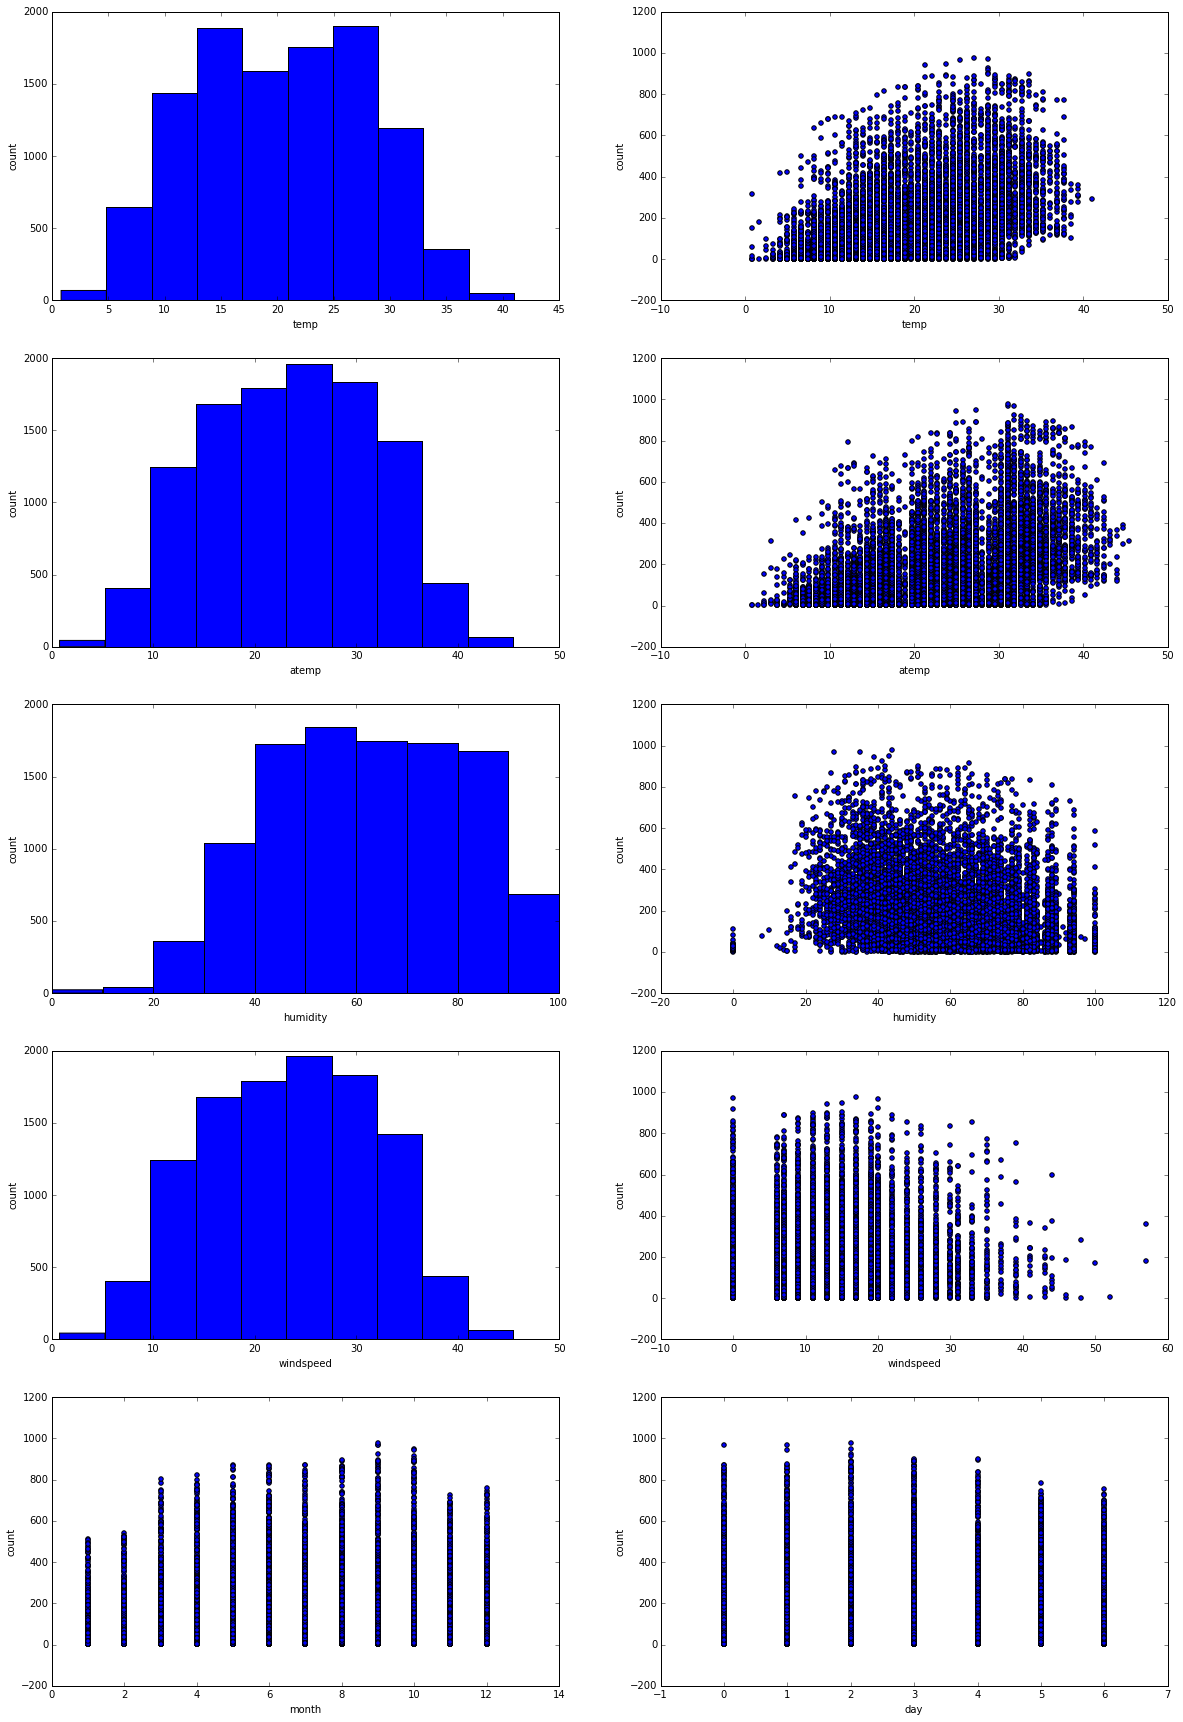

In [34]:
# Exploratory Data Analysis
fig = plt.figure(figsize=(20, 30), dpi=80)
ax1 = fig.add_subplot(521)
ax1.set_xlabel("temp")
ax1.set_ylabel("count")
ax1.hist(df.temp)
ax2 = fig.add_subplot(522)
ax2.set_xlabel("temp")
ax2.set_ylabel("count")
ax2.scatter(df['temp'], df['count'])

ax1 = fig.add_subplot(523)
ax1.set_xlabel("atemp")
ax1.set_ylabel("count")
ax1.hist(df.atemp)
ax2 = fig.add_subplot(524)
ax2.set_xlabel("atemp")
ax2.set_ylabel("count")
ax2.scatter(df['atemp'], df['count'])

ax1 = fig.add_subplot(525)
ax1.set_xlabel("humidity")
ax1.set_ylabel("count")
ax1.hist(df.humidity)
ax2 = fig.add_subplot(526)
ax2.set_xlabel("humidity")
ax2.set_ylabel("count")
ax2.scatter(df['humidity'], df['count'])

ax1 = fig.add_subplot(527)
ax1.set_xlabel("windspeed")
ax1.set_ylabel("count")
ax1.hist(df.atemp)
ax2 = fig.add_subplot(528)
ax2.set_xlabel("windspeed")
ax2.set_ylabel("count")
ax2.scatter(df['windspeed'], df['count'])

ax1 = fig.add_subplot(529)
ax1.set_xlabel("month")
ax1.set_ylabel("count")
ax1.scatter(df['month'], df['count'])

ax1 = fig.add_subplot(5,2,10)
ax1.set_xlabel("day")
ax1.set_ylabel("count")
ax1.scatter(df['day'], df['count'])


In [35]:
# Correlation Matrix
df.corr()

count    season   holiday  workingday   weather      temp  \
count       1.000000  0.163439 -0.005393    0.011594 -0.128655  0.394454   
season      0.163439  1.000000  0.029368   -0.008126  0.008879  0.258689   
holiday    -0.005393  0.029368  1.000000   -0.250491 -0.007074  0.000295   
workingday  0.011594 -0.008126 -0.250491    1.000000  0.033772  0.029966   
weather    -0.128655  0.008879 -0.007074    0.033772  1.000000 -0.055035   
temp        0.394454  0.258689  0.000295    0.029966 -0.055035  1.000000   
atemp       0.389784  0.264744 -0.005215    0.024660 -0.055376  0.984948   
humidity   -0.317371  0.190610  0.001929   -0.010880  0.406244 -0.064949   
windspeed   0.101369 -0.147121  0.008409    0.013373  0.007261 -0.017852   
year        0.260403 -0.004797  0.012021   -0.002482 -0.012548  0.061226   
month       0.166862  0.971524  0.001731   -0.003394  0.012144  0.257589   
hour        0.400601 -0.006546 -0.000354    0.002780 -0.022740  0.145430   
day        -0.002283 -0.010553 -0.191832   -0.704267 -0.047692 -0.038466   
dayofyear   0.168056  0.970196  0.001134   -0.003024  0.011746  0.255887   
week        0.152512  0.939284  0.000976   -0.022593  0.019762  0.240794   
quarter     0.163439  1.000000  0.029368   -0.008126  0.008879  0.258689   
weather1    0.105246 -0.011919 -0.001708   -0.024078 -0.921166  0.058430   
weather2   -0.041329  0.012614  0.013868    0.003324  0.544369 -0.046925   
weather3   -0.117519  0.000860 -0.019514    0.036643  0.730368 -0.025715   
weather4   -0.001459 -0.012938 -0.001644    0.006562  0.039040 -0.014800   
season1    -0.237704 -0.772567 -0.007336   -0.000379  0.005414 -0.565655   
season2     0.075681 -0.262801 -0.038250    0.014620  0.004157  0.192661   
season3     0.136942  0.255939  0.022790   -0.007194 -0.047316  0.635975   
season4     0.023704  0.774867  0.022751   -0.007048  0.037771 -0.266220   

               atemp  humidity  windspeed      year    ...         week  \
count       0.389784 -0.317371   0.101369  0.260403    ...     0.152512   
season      0.264744  0.190610  -0.147121 -0.004797    ...     0.939284   
holiday    -0.005215  0.001929   0.008409  0.012021    ...     0.000976   
workingday  0.024660 -0.010880   0.013373 -0.002482    ...    -0.022593   
weather    -0.055376  0.406244   0.007261 -0.012548    ...     0.019762   
temp        0.984948 -0.064949  -0.017852  0.061226    ...     0.240794   
atemp       1.000000 -0.043536  -0.057473  0.058540    ...     0.248653   
humidity   -0.043536  1.000000  -0.318607 -0.078606    ...     0.216435   
windspeed  -0.057473 -0.318607   1.000000 -0.015221    ...    -0.145962   
year        0.058540 -0.078606  -0.015221  1.000000    ...    -0.003411   
month       0.264173  0.204537  -0.150192 -0.004932    ...     0.961809   
hour        0.140343 -0.278011   0.146631 -0.004234    ...    -0.006532   
day        -0.040235 -0.026507  -0.024804 -0.003785    ...     0.007964   
dayofyear   0.262245  0.203155  -0.148062 -0.000837    ...     0.961538   
week        0.248653  0.216435  -0.145962 -0.003411    ...     1.000000   
quarter     0.264744  0.190610  -0.147121 -0.004797    ...     0.939284   
weather1    0.055825 -0.374837   0.015920 -0.000339    ...    -0.025435   
weather2   -0.040792  0.222398  -0.045016  0.019064    ...     0.026013   
weather3   -0.031154  0.295894   0.045597 -0.030774    ...     0.002873   
weather4   -0.013901  0.012010  -0.007979  0.009548    ...    -0.015266   
season1    -0.569082 -0.166208   0.128819  0.006315    ...    -0.707920   
season2     0.204421 -0.031095   0.042991 -0.002446    ...    -0.270262   
season3     0.607090  0.067308  -0.091521 -0.001598    ...     0.234321   
season4    -0.245690  0.129018  -0.079535 -0.002234    ...     0.739677   

             quarter  weather1  weather2  weather3  weather4   season1  \
count       0.163439  0.105246 -0.041329 -0.117519 -0.001459 -0.237704   
season      1.000000 -0.011919  0.012614  0.000860 -0.012938 -0.772567   
holiday     0.02

In [ ]:
def plot_corr(df,size=30):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
plot_corr(df)

In [ ]:
#scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [ ]:
# Feature Selection
X, Y = feature_selection(df)
print "Shape of all features: ", X.shape
print "Shape of labels: ", Y.shape
KAGGLE_TEST_DATA = feature_selection(KAGGLE_TEST_DATA)
print "Shape of KAGGLE TEST SET: ", KAGGLE_TEST_DATA.shape

In [ ]:
test_data, test_labels = X[9000:], Y[9000:]
dev_data, dev_labels = X[7000:9000], Y[7000:9000]
train_data, train_labels = X[:7000], Y[:7000]
print 'train data shape: ', train_data.shape
print 'train label shape:', train_labels.shape
print 'dev data shape: ', dev_data.shape
print 'dev label shape:', dev_labels.shape
print 'test data shape: ', test_data.shape
print 'test labels shape:', test_labels.shape

In [ ]:
# Commenting out Feature Scaling at this point
#scaler = preprocessing.StandardScaler().fit(train_data)
#test_data_scaled = scaler.transform(test_data)
#dev_data_scaled = scaler.transform(dev_data) 
#train_data_scaled = scaler.transform(train_data) 

In [31]:
def output_model_summary(estimator, dev, test=None):
    '''Prints Model Summary'''
    # The coefficients
    if 'coef_' in dir(estimator):
        print('Coefficients: \n', estimator.coef_)
    print('Intercept: \n', estimator.intercept_)
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((np.rint(estimator.predict(dev)) - dev_labels) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('[DEV] R^2 - Variance score: %.2f' % estimator.score(dev, dev_labels))
    if test:
        print('[TEST] R^2 - Variance score: %.2f' % estimator.score(test, test_labels))

In [ ]:
# Ordinary Least Squares (Baseline)
# Create linear regression object
ols = linear_model.LinearRegression()

# Train the model using the training sets
ols.fit(train_data, train_labels)

# Model Summary
output_model_summary(ols, dev_data, test_data)

In [ ]:
# Kaggle Baseline
def generate_kaggle_submission(pred, f_name):
    print "Shape of Kaggle Test Set: ", KAGGLE_TEST_DATA.shape
    print "Shape of Kaggle Test Set Prediction: ", pred.shape
    pred = np.rint(pred)
    pred = np.where(pred < 0, 0, pred)
    df_pred = pd.DataFrame(pred, columns=['count'])
    
    df_dt = pd.DataFrame(KAGGLE_TEST['datetime'])
    df_dt.reset_index(drop=True, inplace=True)
    
    print df_dt.head()
    print df_pred.head()
    
    output = pd.concat([df_dt, df_pred], axis=1)
    print "Shape of Submission Dataframe: ", output.shape
    print output.head()
    
    file = [os.getcwd(),'/submissions/',f_name]
    output.to_csv("".join(file), index=False)

In [ ]:
# Generate Kaggle Baseline
# Train the model using the entire data set
ols.fit(X, Y)
pred = ols.predict(KAGGLE_TEST_DATA)
generate_kaggle_submission(pred, "baseline.csv")

In [ ]:
# Ridge Regression
clf = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0])

# Train the model using the training sets
clf.fit(train_data, train_labels)

# Model Summary
output_model_summary(clf, dev_data, test_data)

# Kaggle Submission with SVR Linear
clf.fit(X, Y)
pred = clf.predict(KAGGLE_TEST_DATA)
generate_kaggle_submission(pred, "submission_ridge.csv")

In [ ]:
svr = svm.SVR(kernel='linear')

# Train the model using the training sets
svr.fit(train_data, np.squeeze(train_labels))

# Model Summary

output_model_summary(svr, dev_data, test_data)

# Kaggle Submission with SVR Linear
pred = svr.predict(KAGGLE_TEST_DATA)
generate_kaggle_submission(pred, "submission_svr_linear.csv")

In [ ]:
# Polynomial Features
poly = preprocessing.PolynomialFeatures(2)
test_data_poly = poly.fit_transform(test_data)
dev_data_poly = poly.transform(dev_data) 
train_data_poly = poly.transform(train_data) 
print 'train data shape: ', train_data_poly.shape
print 'dev data shape: ', dev_data_poly.shape
print 'test data shape: ', test_data_poly.shape


# Train the model using the training sets
clf.fit(train_data_poly, train_labels)

# Model Summary
output_model_summary(clf, dev_data_poly, test_data_poly)

# Kaggle Submission with Poly Ridge
kaggle_test_poly = poly.transform(KAGGLE_TEST_DATA) 
print 'Kaggle Test Poly Shape: ', kaggle_test_poly.shape
pred = clf.predict(kaggle_test_poly)
generate_kaggle_submission(pred, "submission_poly_ridge.csv")